# Prices Simulation from Welzia xlsx

We will see a simple example of how to simulated prices from an Excel file provide by Welzia.

## 1. Load the historical data

The historical prices are stored in the ``df`` variable as a ``pd.DataFrame``.

In [1]:
from portfolioqtopt.reader import read_welzia_stocks_file

file_path = "/home/ggelabert/Projects/PortfolioQtOpt/data/Histórico carteras Welzia Completo.xlsm"
sheet_name = "BBG (valores)"

df = read_welzia_stocks_file(file_path, sheet_name)

Visualize the ``df`` contents.

In [2]:
display(df.head(3))

TICKER_AND_EXCH_CODE,DEXHISI LX Equity,DWSGIFC LX Equity,FIDFTEE LX Equity,SCUSIHA LX Equity,VONEMBI LX Equity,ABEFRIA LX Equity,CARSECC FP Equity,STWDGRE ID Equity,SYCPARP FP Equity,VONEMHI LX Equity,...,RENDGAR LX Equity,SCHGOCH LX Equity,SALRFE1 ID Equity,VECNAVI LX Equity,BFLBBIE LX Equity,LFPLIBR FP Equity,CMNTREI FP Equity,PIMGIIA ID Equity,PAMEULF BB Equity,SCHGVCE LX Equity
2010-01-01,140.11,81.28,5.794,87.3,476.54,51.69,1492.40002,78.55,1010.59,82.34,...,80.37,98.24,104.56,757.82,138.04,1366.57,104558.81,12.35,93.32,89.17
2010-01-02,140.11,81.28,5.794,87.3,476.54,51.69,1492.40002,78.55,1010.59,82.34,...,80.37,98.24,104.56,757.82,138.04,1366.57,104558.81,12.35,93.32,89.17
2010-01-03,140.11,81.28,5.794,87.3,476.54,51.69,1492.40002,78.55,1010.59,82.34,...,80.37,98.24,104.56,757.82,138.04,1366.57,104558.81,12.35,93.32,89.17


## 2. Make a prevision of the anual expected return

We define expected annual returns as a dictionary that we called ``era`` and a number of simulated prices ``ns`` to be predicted for each stock.  
As there are 45 assets, we generate the prediction randomly for the purposes of the example.

In [11]:
import numpy as np
import pandas as pd

np.random.seed(42)

simulated_expected_returns = np.random.random(df.shape[1]) * 0.1
ear = dict(zip(df.columns, simulated_expected_returns))
ns = 254

pd.DataFrame.from_dict(ear, orient="index", columns=["expected return"]).T

,DEXHISI LX Equity,DWSGIFC LX Equity,FIDFTEE LX Equity,SCUSIHA LX Equity,VONEMBI LX Equity,ABEFRIA LX Equity,CARSECC FP Equity,STWDGRE ID Equity,SYCPARP FP Equity,VONEMHI LX Equity,...,RENDGAR LX Equity,SCHGOCH LX Equity,SALRFE1 ID Equity,VECNAVI LX Equity,BFLBBIE LX Equity,LFPLIBR FP Equity,CMNTREI FP Equity,PIMGIIA ID Equity,PAMEULF BB Equity,SCHGVCE LX Equity
expected return,0.037454,0.095071,0.073199,0.059866,0.015602,0.015599,0.005808,0.086618,0.060112,0.070807,...,0.083244,0.021234,0.018182,0.01834,0.030424,0.052476,0.043195,0.029123,0.061185,0.013949


## 3. Simulate future prices

1. Check that ``df_prices`` contains prices using the ``Assets`` object.


In [29]:
from portfolioqtopt.assets import Assets
from portfolioqtopt.simulation.simulation import Simulation

assets_history = Assets(df=df)

2. Create the ``simulation`` instance of the ``Simulation`` class.

In [12]:
simulation = Simulation(assets_history, er=ear, ns=ns)

3. Make the simulation with the given historical stock prices, the anual expected returns and the numbers of days. The results is a ``tuple`` containing future returns, covariance and prices respectively names ``future_returns``, ``future_cov``, ``future_prices``.

In [14]:
from loguru import logger

logger.disable("portfolioqtopt")

future_prices = simulation(order=12)

1. Plot the historical prices followed by the simulated prices on the same graph. We remove the assets with the highest prices so that the plot does not appear flat!

(4985, 6)


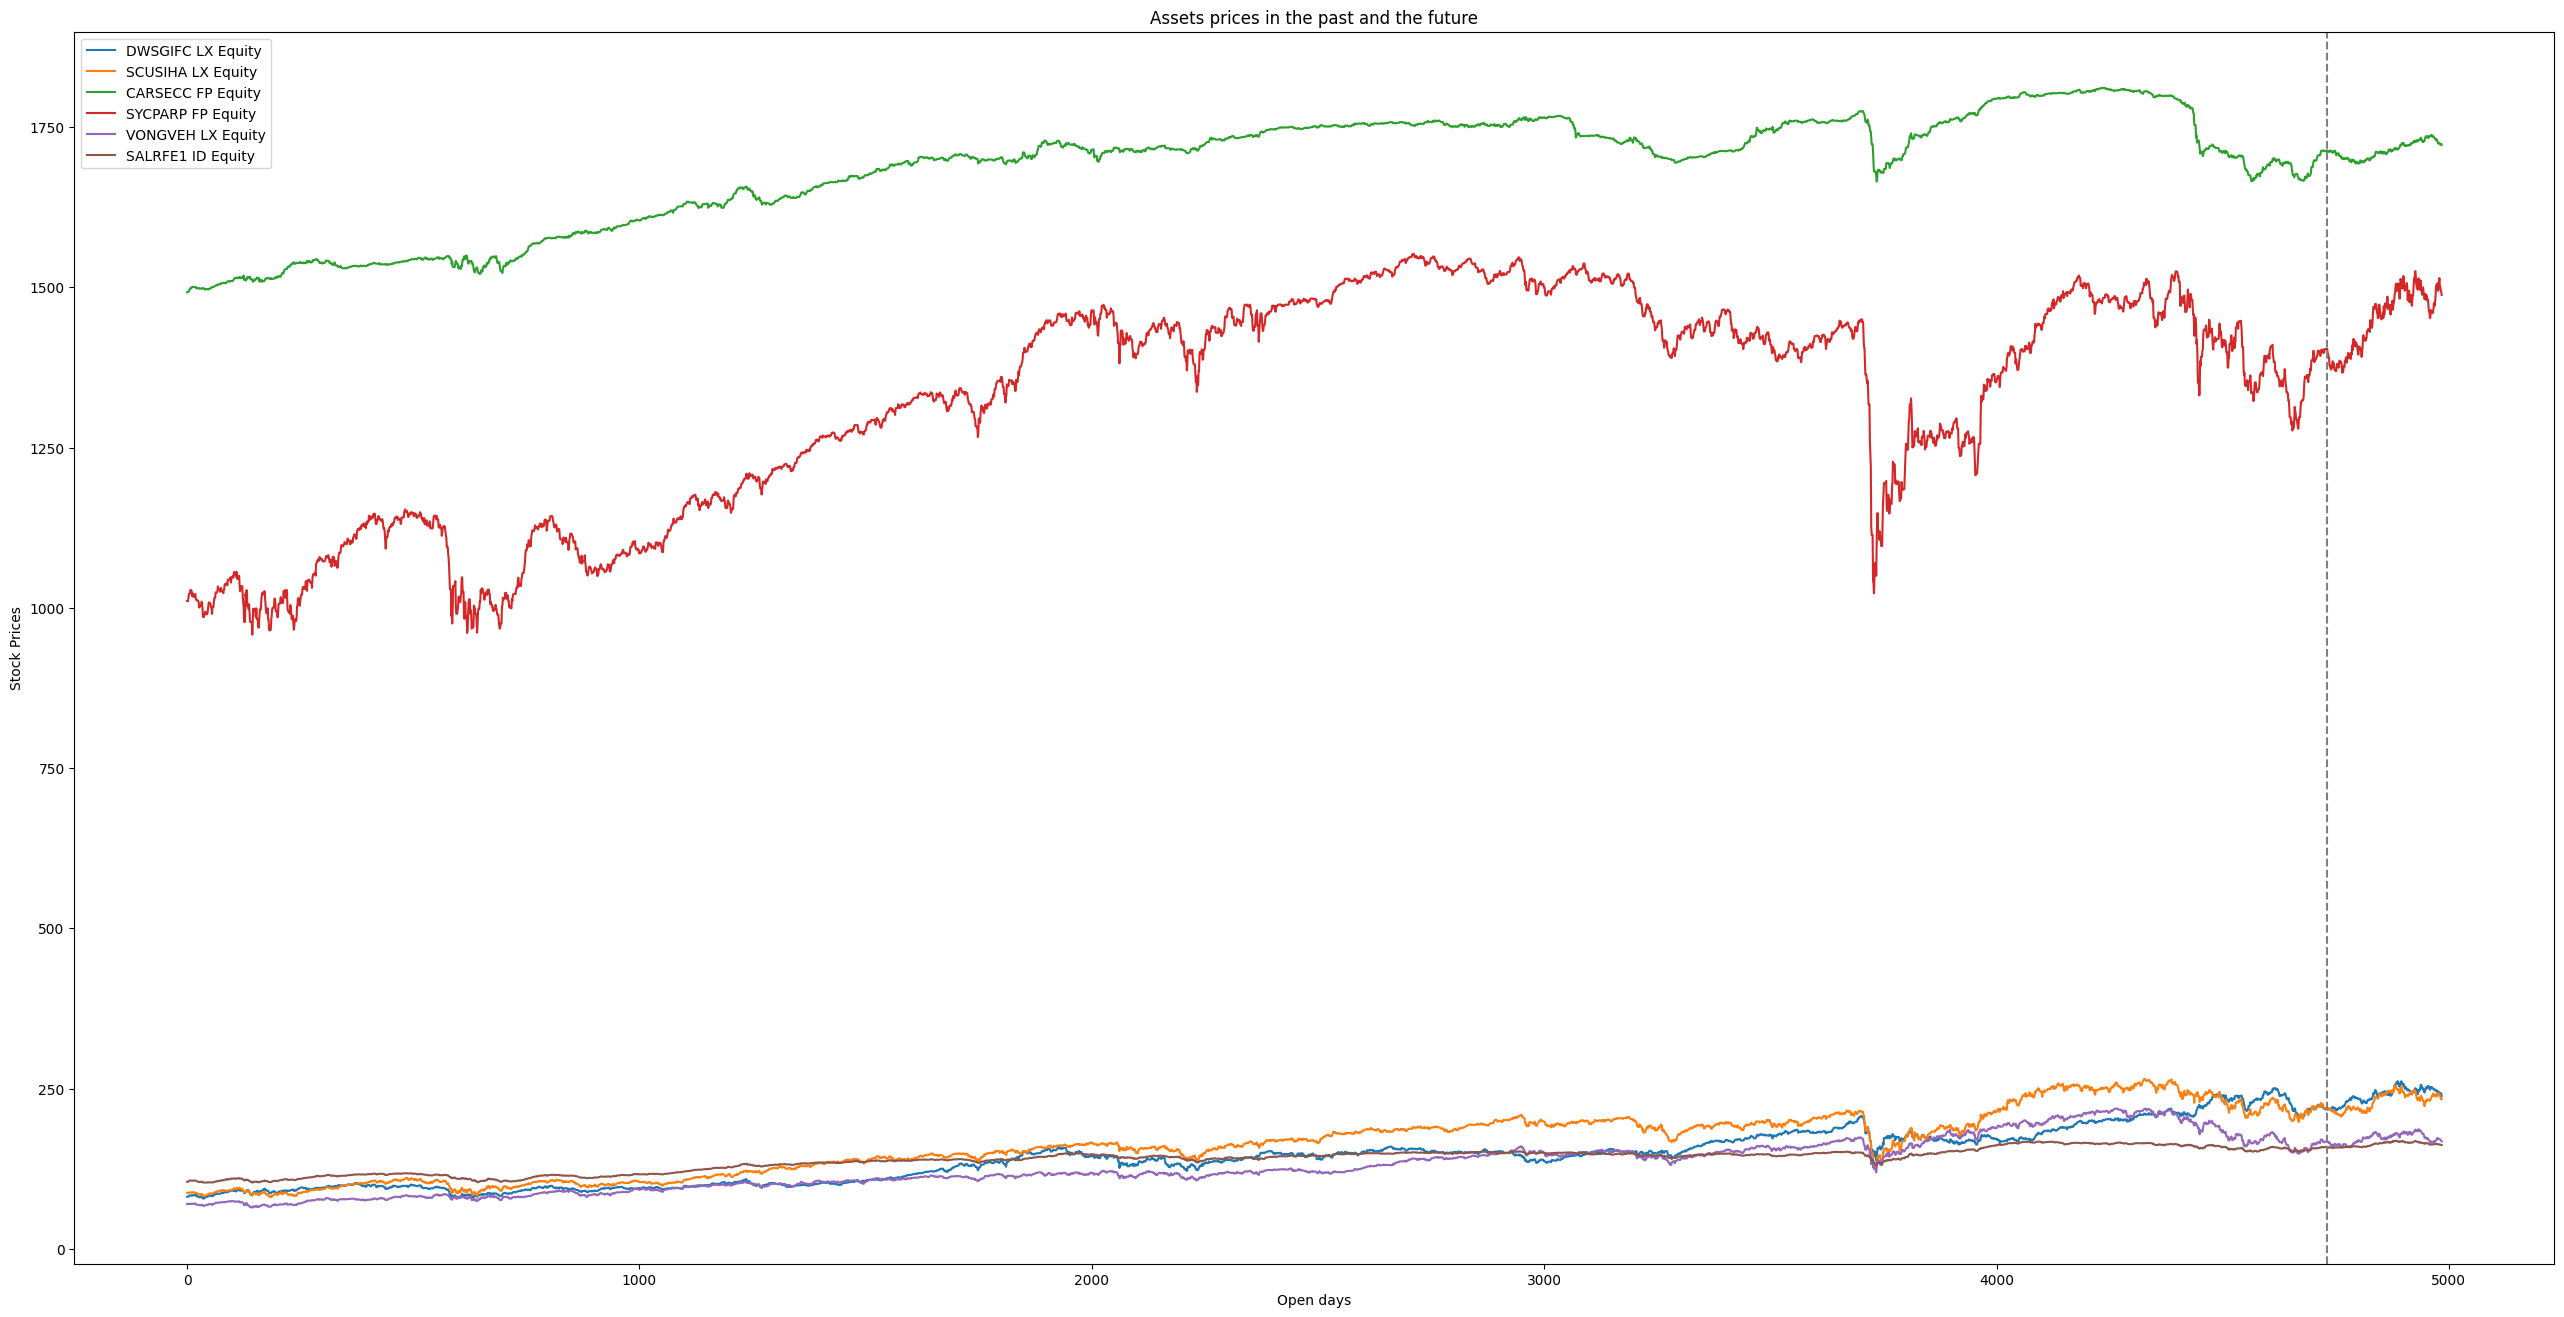

In [37]:
import numpy as np
import matplotlib.pyplot as plt

reduce_set = np.array([1, 3, 6, 8, 10, 14])
prices = np.vstack((assets_history[reduce_set].prices, future_prices[reduce_set].prices))  # shape (nh + nf, k)
print(prices.shape)

fig, ax = plt.subplots(figsize=(32, 16))
ax.set_title("Assets prices in the past and the future")
ax.plot(prices, label=assets_history[reduce_set].df.columns)
ax.axvline(x=assets_history.n, ymin=0, ymax=1, c="grey", linestyle="--")
ax.set_xlabel("Open days")
ax.set_ylabel("Stock Prices")
ax.legend();

## 4. Finally verify the quality of the results

To be sure that all is as expected we verify that:

1. The covariance of the daily returns of our simulated prices are the same as the historical one.  

In [39]:
import numpy as np

np.testing.assert_allclose(future_prices.cov, assets_history.cov)

2. The simulated anual returns are the same as the desired anual returns.  
    For that the `Simulation` class first reorder the `ear` dictionary in order to ensure that all the values of `simulation.er` correspond to the same asset as the `future_prices.anual_returns` value.

In [40]:
np.testing.assert_allclose(future_prices.anual_returns, simulation.er)

All work as expected!